In [107]:
# Data update functionality
import os
from pathlib import Path
from fabric import ThreadingGroup,Connection
from fabric.transfer import Transfer

# global configuration parameters
experiment_type = "random"
exploration_name = "Exploration_2"

hosts = []
with open(str(Path("~/.ssh/config").expanduser()),'r') as f:
    for line in f.readlines():
        if "HostName" in line:
            ip = line.strip(" ").split(" ")[2].strip('\n')
            if ip != r'None':
                hosts.append(ip)

key_file_loc = "/Users/sfeygi/.ssh/beam_competitions_key.pem"
dest_root = "/Users/sfeygi/current_code/others/prize_starter_kit/search-output/{}/{}/".format(exploration_name,experiment_type)

def connect_parallel(hosts,key_file_loc):
    return ThreadingGroup(*hosts,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def connect_single(host, key_file_loc):
    return Connection(host,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def run(cmd, connection):
    return connection.run(cmd)

def run_n(cmd, connections):
    return [run(cmd,connection) for connection in connections]

def rsync_results(hostname, host_ip, key_file_loc, dest_root,exploration_name,experiment_type):
    experiment_type = 'random_inputs' if experiment_type == 'random' else experiment_type
    return os.system(
        'rsync -avz -e "ssh -i {key_file_loc}" ubuntu@{host_ip}:/home/ubuntu//Uber-Prize-Starter-Kit/search-output-{exploration_name}-{experiment_type}/ {dest_root}{hostname} --exclude="*/ITERS/" --exclude="*/output*" --exclude="*/competition/viz/" --exclude="*/summaryStats/"'.format(
            exploration_name=exploration_name,experiment_type=experiment_type,dest_root=dest_root,key_file_loc=key_file_loc, hostname=hostname, host_ip=host_ip))

# global other
host_names = ["host{}".format(str(i + 1)) for i in range(len(hosts))]
connection = connect_parallel(hosts,key_file_loc)

In [108]:
# try:
#     run('cd /home/ubuntu/Uber-Prize-Starter-Kit/utilities &&  \
#         git pull origin vgv/#55-adapt_ramdom_search', connection)
# except UnexpectedExit:
#     print("Already pulled in latest!")
# Ensure that docker image on server is latest (somewhat orthogonal to this notebook, but leaving here for now)
run('docker pull beammodel/beam-competition:0.0.1-SNAPSHOT',connection)


0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
Digest: sha256:a449c2a3c6f4d9eeaa9d0388ae2c2fcc50e5595a11c5b0b57b594fd710a59a37
Status: Image is up to date for beammodel/beam-competition:0.0.1-SNAPSHOT
54f7e8ac135a: Already exists
d6341e30912f: Already exists
087a57faf949: Already exists
5d71636fb824: Already exists
0c1db9598990: Already exists
2eeb5ce9b924: Already exists
5b17b6f4d4e0: Already exists
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
54f7e8ac135a: Already exists
f1abee0af377: Already exists
298587aefca5: Already exists
d19a52a4201b: Already exists
c4b97e37313f: Already exists
0da75cc02c04: Already exists
01556cb5c24d: Already exists
59cec1e23469: Already exists
a4e8cfda4e7e: Already exists
c2c7d8e9c50f: Already exists
26431a57825a: Already exists
916606cef963: Already exists
77e7c1d02cf0: Already exists
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
54f7e8ac135a: Already exists
d6341e30912f:

c8f12abfa6c8: Download complete
b0b9c3023e37: Verifying Checksum
b0b9c3023e37: Download complete
b0b9c3023e37: Verifying Checksum
b0b9c3023e37: Download complete
c8f12abfa6c8: Verifying Checksum
c8f12abfa6c8: Download complete
47f449dbd55a: Verifying Checksum
47f449dbd55a: Download complete
47f449dbd55a: Verifying Checksum
47f449dbd55a: Download complete
47f449dbd55a: Verifying Checksum
47f449dbd55a: Download complete
abe65fb5852a: Verifying Checksum
abe65fb5852a: Download complete
47f449dbd55a: Verifying Checksum
47f449dbd55a: Download complete
47f449dbd55a: Verifying Checksum
47f449dbd55a: Download complete
b0b9c3023e37: Verifying Checksum
b0b9c3023e37: Download complete
abe65fb5852a: Download complete
abe65fb5852a: Verifying Checksum
abe65fb5852a: Download complete
abe65fb5852a: Verifying Checksum
abe65fb5852a: Download complete
abe65fb5852a: Verifying Checksum
abe65fb5852a: Download complete
47f449dbd55a: Verifying Checksum
47f449dbd55a: Download complete
abe65fb5852a: Download com

{<Connection host=52.13.145.44 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.202.221.118 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=34.210.88.9 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=52.89.179.9 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.218.29.151 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=34.217.44.162 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.218.172.167 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.191.161.231 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>}

In [6]:
# Pull latest results from server
[rsync_results(hostname, host_ip, key_file_loc,dest_root,exploration_name,experiment_type) for hostname, host_ip in list(zip(host_names, hosts))]

[0, 0, 0, 0, 0, 5120, 5120, 5120]

In [61]:
import pandas as pd
import seaborn as sns
# import dask.dataframe as dd
import numpy as np
from collections import defaultdict
import re
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [62]:
%matplotlib inline

In [63]:
# Parsing utilities
def split_range(range_repr):
    """
    Split's out a mathematial range representation into its component bounds.
    
    Exclusive ('(',')') bounds will have the left and/or right bounds properly
    augmented with +1 and -1, respectively. Inclusive bounds ('[',']') will remain
    as written.
    
    Parameters
    ----------
    range_repr : str
        A formatted representation of the range with exclusive and inclusive
        bounds represented as '(',')' and/or '[',']', respectively, for example,
        the range "(300:500]" represents all numbers between 300 (exclusive) and 500
        (inclusive).
    
    Returns
    -------
    str
        The input range representation as pair of integers with the ':' remaining to permit
        easy splitting with the series `str.split` function when the `expand` argument is `True`.
    
    Examples
    --------
    >>> split_range("(47000:202000]")
    '47001:202000'
    >>> split_range("(47000:202000]")
    '155000:176000'
    
    """
    if isinstance(range_repr,float):
        return "0:120"
    l,r = range_repr.strip("(),[]").split(":")
    l = int(l) + 1 if range_repr[0] is '(' else int(l) + 0
    r = int(r) - 1 if range_repr[-1] is ')' else int(r) + 0
    return "{}:{}".format(l,r)

# input_db = pd.concat(all_input_dfs).set_index("output_key")
def concat_and_set_index(df,name):
    return pd.concat(df[name]).set_index("output_key")
def expand_range_column(in_df,field):
    in_series = in_df.loc[:,field]
    in_df = in_series.apply(split_range).str.split(":",expand=True)
    in_df.columns = ["{}_low".format(field),"{}_high".format(field)]
#     in_df
    return in_df

def split_input_range(input_df,input_fields):
    tmp_res = []
    for input_field in input_fields:
        split_input_field=expand_range_column(input_df,input_field)
        input_df.drop(input_field,axis=1,inplace=True)
        tmp_res.append(split_input_field)
    input_type_df = pd.concat(tmp_res,axis=1)
    return pd.concat([input_df,input_type_df],axis=1)

def merge_input_type_df_with_score(input_df,scores_df,score_type):
    sub_scores = scores_df.loc[score_type]
    score_df = pd.merge(sub_scores,input_df,how="outer",right_index=True,left_on="output_key").set_index("output_key")
    return score_df.dropna(axis=0)

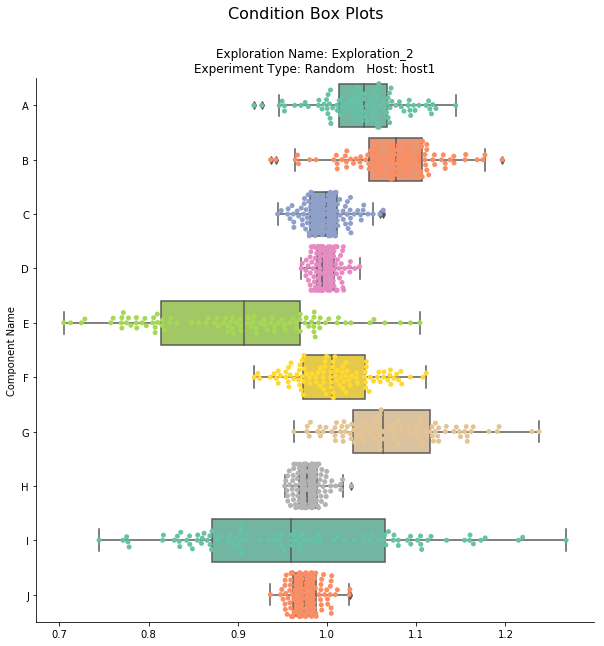

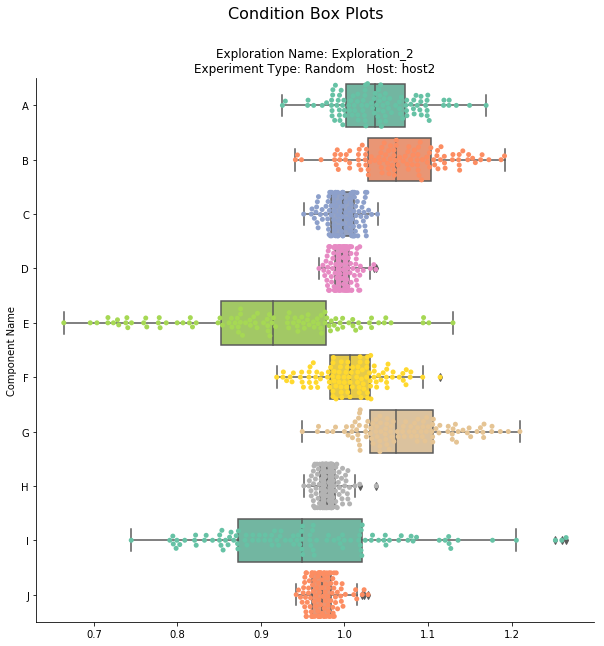

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



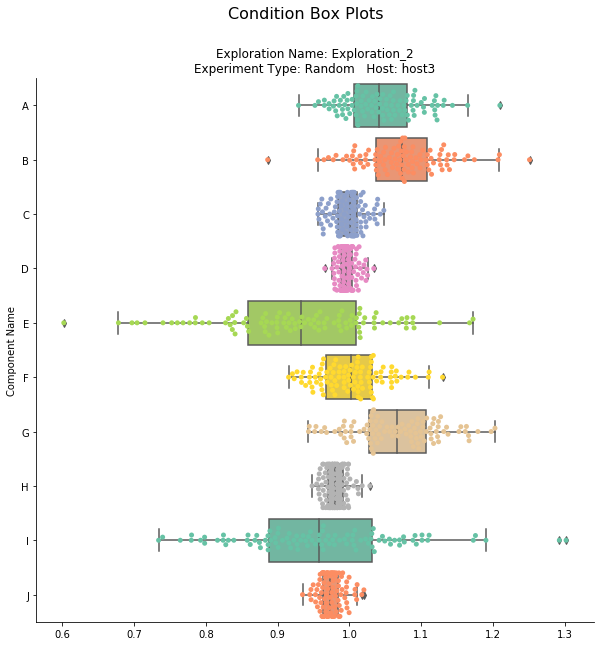

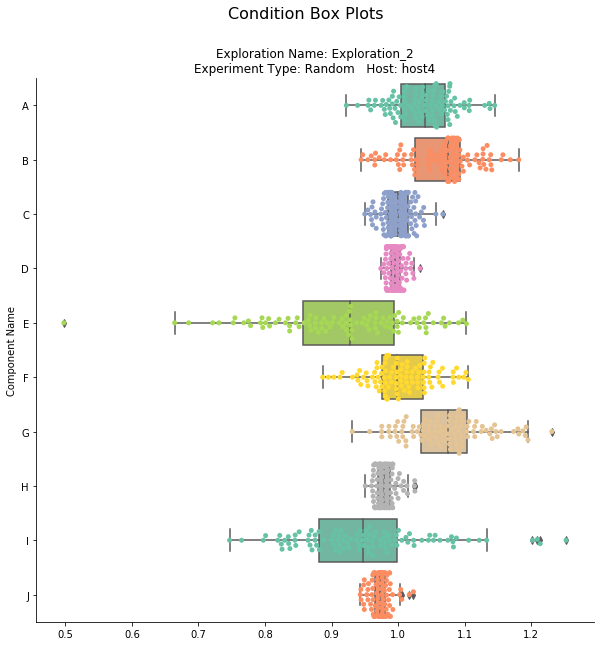

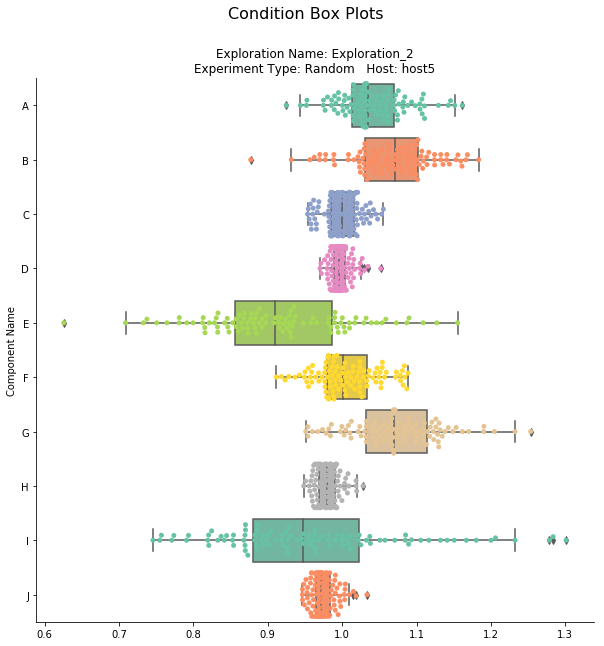

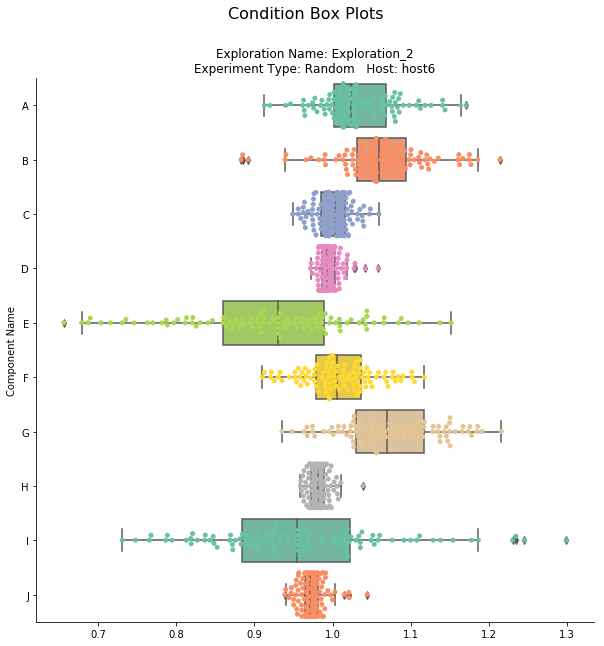

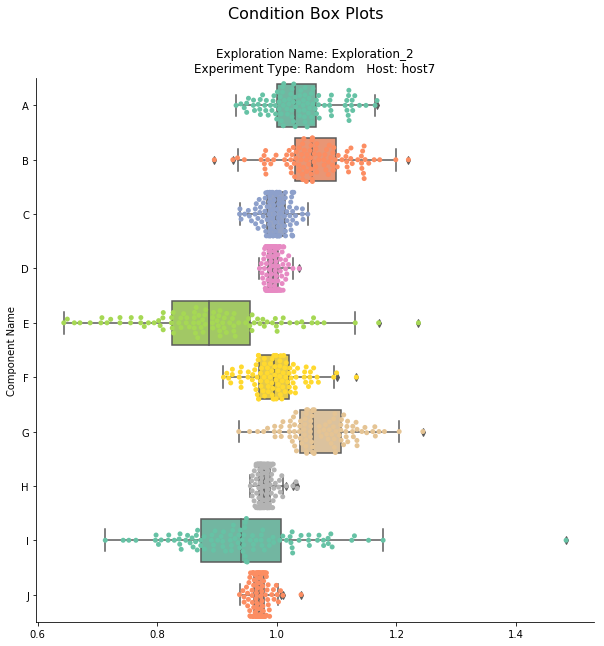

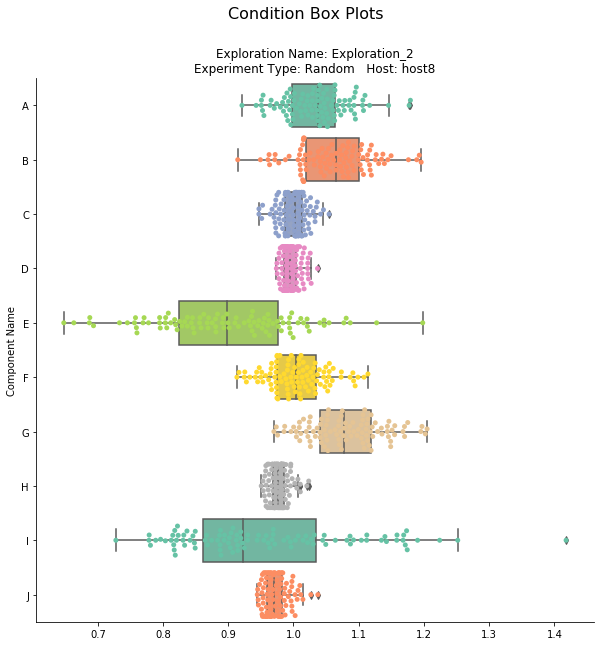

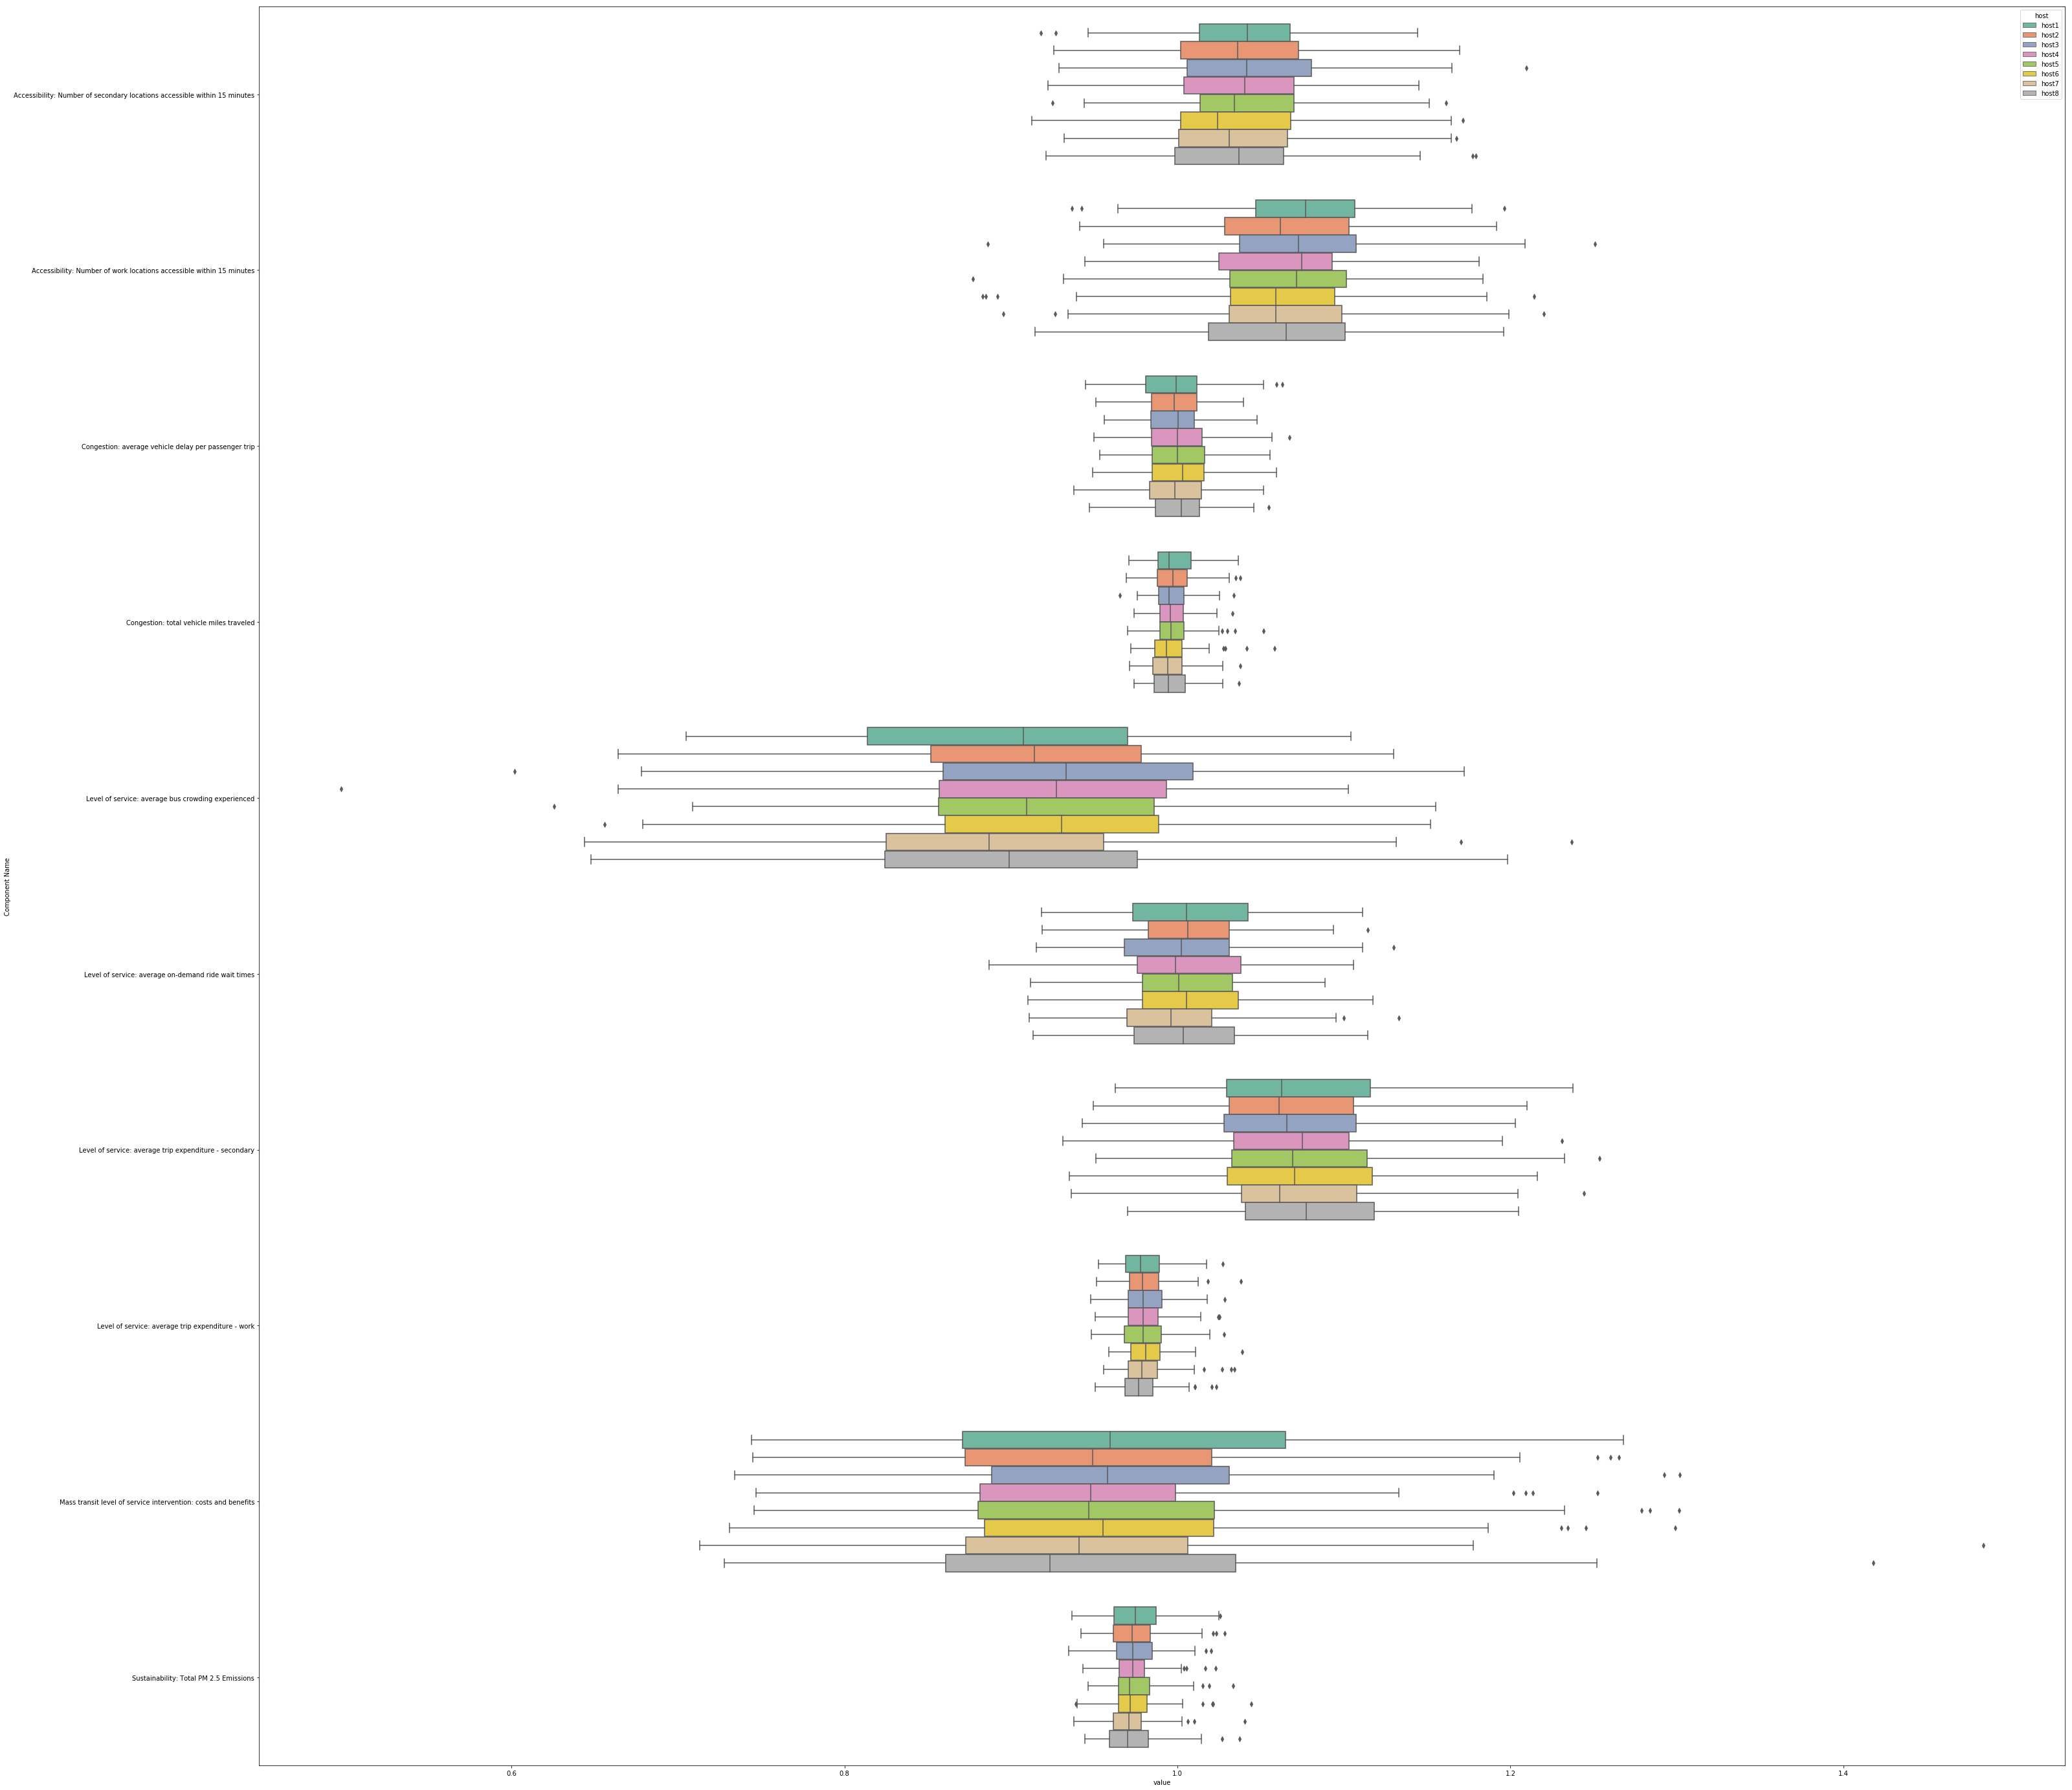

In [64]:
# collect, parse, and concatenate scores as well as plot by condition
import glob
experiment_types = ['random']
exploration_name = 'Exploration_2'
wide_score_dfs = []
for experiment_type in experiment_types:

    scores_dfs={}
    for host in host_names:
        try:
            common="../search-output/{}/{}/{}/".format(exploration_name,experiment_type,host)
            output_dirs = glob.glob(common+"output*/sioux_faux/sioux_faux-15k*/competition/")


            sub_score_dfs = []
            all_input_dfs = defaultdict(list)
            SUBMISSION_INPUTS_DIR_NAME = "submission-inputs/"
            SUB_SCORE_NAME = "submissionScores.csv"
            input_names = ("FrequencyAdjustment","ModeIncentives","MassTransitFares","VehicleFleetMix")

            for output_dir in output_dirs:
                # Load sub_score_dfs
                sub_score_file = output_dir + SUB_SCORE_NAME
                if not Path(sub_score_file).is_file():
                    continue
                score_df = pd.read_csv(sub_score_file,index_col="Component Name")
                output_key = re.findall("^.*output[_|-](.*?)(?:/sioux.*)$",output_dir)[0]
                if "RS" not in output_key:  # filter out old runs for now
                    continue
                score_df.loc[:,"output_key"] = output_key
                sub_score_dfs.append(score_df[["Raw Score","output_key"]])

                for input_name in input_names:
                    input_file = output_dir + SUBMISSION_INPUTS_DIR_NAME +"/"+ input_name+".csv"
                    if input_name == 'ModeIncentives':
                        input_df = pd.read_csv(input_file,dtype={'age':str})
                    else:
                        input_df = pd.read_csv(input_file)
                    if input_df.shape[0] == 0:
                        continue
                    input_df.loc[:,"output_key"] = output_key
                    input_df.index.name = 'obs_num'
                    all_input_dfs[input_name].append(input_df)


            freq_df = concat_and_set_index(all_input_dfs,"FrequencyAdjustment").drop('exact_times',axis=1)
            mode_df = concat_and_set_index(all_input_dfs,"ModeIncentives")
            ptfare_df = concat_and_set_index(all_input_dfs,"MassTransitFares")
            vfm_df = concat_and_set_index(all_input_dfs,"VehicleFleetMix").drop("agencyId",axis=1)

            trip_id_factors = pd.factorize(freq_df.loc[:,"trip_id"])
            freq_df.loc[:,"trip_id"]=trip_id_factors[0]

            mode_factors = pd.factorize(mode_df.loc[:,"mode"])
            mode_df.loc[:,"mode"]=mode_factors[0]

            a,b = pd.factorize(list(set(ptfare_df.loc[:, "routeId"].values).union(set(ptfare_df.loc[:,"routeId"]))))
            mapping = dict(zip(b,a))
            ptfare_df.loc[:,"routeId"]=ptfare_df.loc[:,"routeId"].apply(lambda x: mapping[x])
            vfm_df.loc[:, "routeId"] = vfm_df.loc[:, "routeId"].apply(lambda x: mapping[x])

            vehicle_type_factors = pd.factorize(vfm_df.loc[:,"vehicleTypeId"])
            vfm_df.loc[:,"vehicleTypeId"] = vehicle_type_factors[0]

            input_type = "ModeIncentives"
            input_fields = ["income","age"]
            mode_df = split_input_range(mode_df.copy(),input_fields)

            input_type = "MassTransitFares"
            input_fields = ["age"]
            ptfare_df = split_input_range(ptfare_df.copy(),input_fields)

            scores_df = pd.concat(sub_score_dfs)

            score_type = "Submission Score"
            freq_subscore_df = merge_input_type_df_with_score(freq_df,scores_df,score_type)
            mode_subscore_df = merge_input_type_df_with_score(mode_df,scores_df,score_type)
            ptfare_subscore_df = merge_input_type_df_with_score(ptfare_df,scores_df,score_type)
            vfm_subscore_df = merge_input_type_df_with_score(vfm_df,scores_df,score_type)

            freq_subscore_df=freq_subscore_df[freq_subscore_df["Raw Score"]>0]
            scores_df_wide = scores_df.reset_index().pivot(index='output_key',columns='Component Name',values='Raw Score')
            scores_dfs[host] = scores_df_wide
            fig = plt.figure(figsize=(10,10))
            
            # For plotting:
            
            sns.boxplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2')
            sns.swarmplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2',color=".25")
            axis = fig.axes[0]
        #     axis.set_xlim(-0.25,5.0)
            plt.suptitle('Condition Box Plots',fontsize=16)
            plt.title("Exploration Name: {}\nExperiment Type: {}   Host: {}".format(exploration_name, experiment_type.title(),host))
            axis.set_yticklabels(['A','B','C','D','E','F','G','H','I','J'])
            sns.despine()
            plt.show()

            fig.savefig("img/{}/{}/{}.png".format(exploration_name,experiment_type, host),format="png",dpi=150)
            plt.close()
        except ValueError:
            pass
    for k,df in scores_dfs.items():
        df['host'] = k
    wide_scores = pd.concat(list(scores_dfs.values()),axis=0)
    wide_scores = wide_scores.drop(['Submission Score','host'],axis=1).astype('float')
    wide_scores.to_csv('img/{}/wide-scores_{}_{}.csv'.format(exploration_name,experiment_type,exploration_name,experiment_type))

    # Plot the full distribution across worker nodes
    grouped = pd.concat(list(scores_dfs.values()))
    melted=pd.melt(grouped.drop("Submission Score",axis=1),id_vars='host')
    fig = plt.figure(figsize=(50,50))

    sns.boxplot(y='Component Name',x='value',hue='host',data=melted,orient='h',palette='Set2')
    fig.savefig('img/{}/{}/grouped.png'.format(exploration_name,experiment_type),dpi=300)
    
    wide_score_dfs.append(wide_scores)


In [337]:
wide_scores = pd.concat(wide_score_dfs,axis=0)
wide_scores.iloc[:,:2]=np.reciprocal(wide_scores.iloc[:,:2])
wide_scores['Mass transit level of service intervention: costs and benefits'] = np.reciprocal(wide_scores['Mass transit level of service intervention: costs and benefits'])

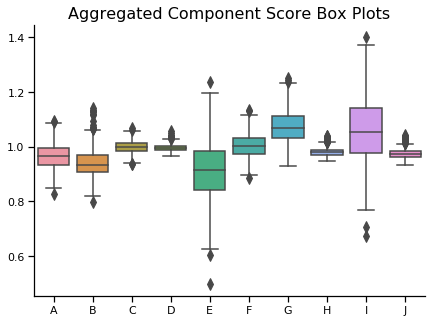

In [30]:
sns.set_context('notebook')
sns.set_palette('Set1')

fig, ax = plt.subplots()
fig.set_size_inches(7,5)
columns = ['A','B','C','D','E','F','G','H','I','J']
ser = []
for i in range(10):
    ser.append(wide_scores.T.iloc[i].values)
sns.boxplot(y=ser,x=columns,orient='v',fliersize=8)
plt.title('Aggregated Component Score Box Plots',fontsize=16)
# plt.title("Random Search over Input Space")
sns.despine()


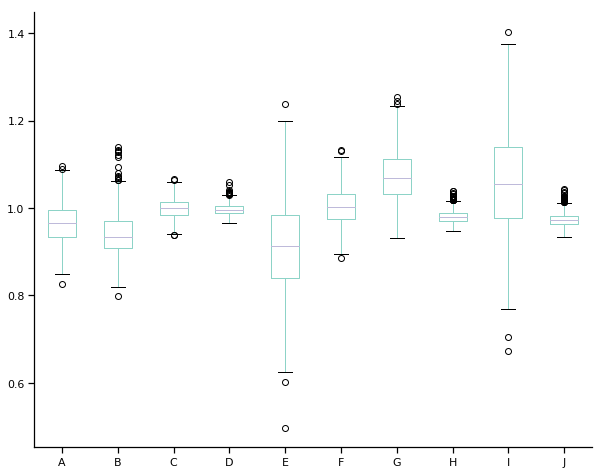

In [338]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set_palette('Set3')
sns.despine()
pd.DataFrame(dict(zip(columns,ser))).plot(kind='box',ax=ax)
fig.savefig('img/{}/{}/aggregate_box.png'.format(exploration_name,experiment_type),dpi=300)

In [17]:
best_scores = wide_scores.iloc[np.argmin(wide_scores.values,0)]

In [18]:
best_access_dict={"Accessibility: Number of secondary locations accessible within 15 minutes":"C9_RS73-xjk8_7hu",
"Accessibility: Number of work locations accessible within 15 minutes":"C9_RS73-xjk8_7hu"}
best_access_dict.update(dict(zip(best_scores.columns.values.tolist(),best_scores.index.values.tolist()[2:])))
best_access_dict

{'Accessibility: Number of secondary locations accessible within 15 minutes': 'C9_RS59-0zus3wmt',
 'Accessibility: Number of work locations accessible within 15 minutes': 'C9_RS26-9519154u',
 'Congestion: average vehicle delay per passenger trip': 'C9_RS69-y8otrrg4',
 'Congestion: total vehicle miles traveled': 'C9_RS100-52ps1o9z',
 'Level of service: average bus crowding experienced': 'C9_RS97-30cg0x2q',
 'Level of service: average on-demand ride wait times': 'C9_RS72-_v7bxwyw',
 'Level of service: average trip expenditure - secondary': 'C9_RS18-a8aybkhu',
 'Level of service: average trip expenditure - work': 'C9_RS26-9519154u'}

In [19]:
dict(zip(best_scores.columns.values.tolist(),np.diag(best_scores.values.tolist())[2:]))
# dict(zip(access_best.iloc[0:2].values.tolist(),np.diag(access_best.iloc[0:2].values.tolist())))

{'Accessibility: Number of secondary locations accessible within 15 minutes': 0.9377328907308662,
 'Accessibility: Number of work locations accessible within 15 minutes': 0.9654948017334828,
 'Congestion: average vehicle delay per passenger trip': 0.4977142256480272,
 'Congestion: total vehicle miles traveled': 0.8867055968432159,
 'Level of service: average bus crowding experienced': 0.9310459146491464,
 'Level of service: average on-demand ride wait times': 0.947876781259804,
 'Level of service: average trip expenditure - secondary': 0.6739273536389512,
 'Level of service: average trip expenditure - work': 0.9345677371034558}

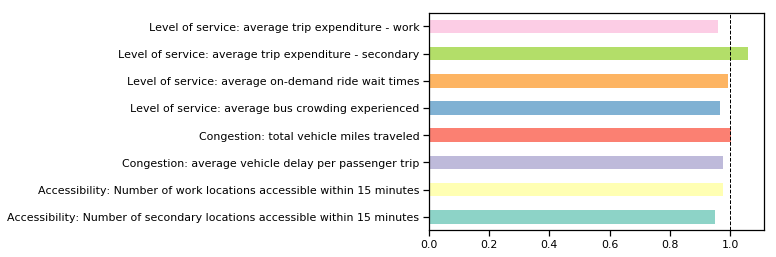

In [21]:
pd.Series(dict(zip(best_scores.columns.values.tolist(),np.diag(best_scores.values[2:]).tolist()))).plot(kind='barh')
plt.axvline(x=1.0,linewidth=1, color='k', ls='dashed', label = "baseline")


In [22]:
worst_scores = wide_scores.iloc[np.argmax(wide_scores.values,0)]

In [23]:
dict(zip(worst_scores.columns.values.tolist(),best_scores.index.values.tolist()))

{'Accessibility: Number of secondary locations accessible within 15 minutes': 'C9_RS73-xjk8_7hu',
 'Accessibility: Number of work locations accessible within 15 minutes': 'C9_RS73-xjk8_7hu',
 'Congestion: average vehicle delay per passenger trip': 'C9_RS59-0zus3wmt',
 'Congestion: total vehicle miles traveled': 'C9_RS26-9519154u',
 'Level of service: average bus crowding experienced': 'C9_RS69-y8otrrg4',
 'Level of service: average on-demand ride wait times': 'C9_RS100-52ps1o9z',
 'Level of service: average trip expenditure - secondary': 'C9_RS97-30cg0x2q',
 'Level of service: average trip expenditure - work': 'C9_RS72-_v7bxwyw',
 'Mass transit level of service intervention: costs and benefits': 'C9_RS18-a8aybkhu',
 'Sustainability: Total PM 2.5 Emissions': 'C9_RS26-9519154u'}

In [25]:
dict(zip(worst_scores.columns.values.tolist(),np.diag(best_scores.values).tolist()))

{'Accessibility: Number of secondary locations accessible within 15 minutes': 0.8267406077581061,
 'Accessibility: Number of work locations accessible within 15 minutes': 0.7994253354612122,
 'Congestion: average vehicle delay per passenger trip': 0.9377328907308662,
 'Congestion: total vehicle miles traveled': 0.9654948017334828,
 'Level of service: average bus crowding experienced': 0.4977142256480272,
 'Level of service: average on-demand ride wait times': 0.8867055968432159,
 'Level of service: average trip expenditure - secondary': 0.9310459146491464,
 'Level of service: average trip expenditure - work': 0.947876781259804,
 'Mass transit level of service intervention: costs and benefits': 0.6739273536389512,
 'Sustainability: Total PM 2.5 Emissions': 0.9345677371034558}

In [26]:
import pandas as pd, numpy as np
# wide_scores = pd.read_csv("img/random/wide-scores_random.csv")
wide_scores.describe()

Component Name,Accessibility: Number of secondary locations accessible within 15 minutes,Accessibility: Number of work locations accessible within 15 minutes,Congestion: average vehicle delay per passenger trip,Congestion: total vehicle miles traveled,Level of service: average bus crowding experienced,Level of service: average on-demand ride wait times,Level of service: average trip expenditure - secondary,Level of service: average trip expenditure - work,Mass transit level of service intervention: costs and benefits,Sustainability: Total PM 2.5 Emissions
count,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000
mean,0.965092,0.940043,0.999018,0.996799,0.908925,1.004617,1.072755,0.980418,1.057447,0.973988
std,0.044889,0.049810,0.022469,0.013009,0.104388,0.043546,0.058042,0.014693,0.120255,0.016578
min,0.826741,0.799425,0.937733,0.965495,0.497714,0.886706,0.931046,0.947877,0.673927,0.934568
25%,0.934778,0.907583,0.984005,0.987695,0.840575,0.974578,1.031784,0.970316,0.976615,0.962763
50%,0.964817,0.934763,1.000021,0.995019,0.913365,1.002625,1.069511,0.979135,1.055521,0.972050
75%,0.996003,0.969738,1.014183,1.004159,0.984153,1.032821,1.112231,0.989118,1.140369,0.982594
max,1.095692,1.140095,1.067178,1.058423,1.236918,1.133071,1.253429,1.038789,1.402264,1.044438


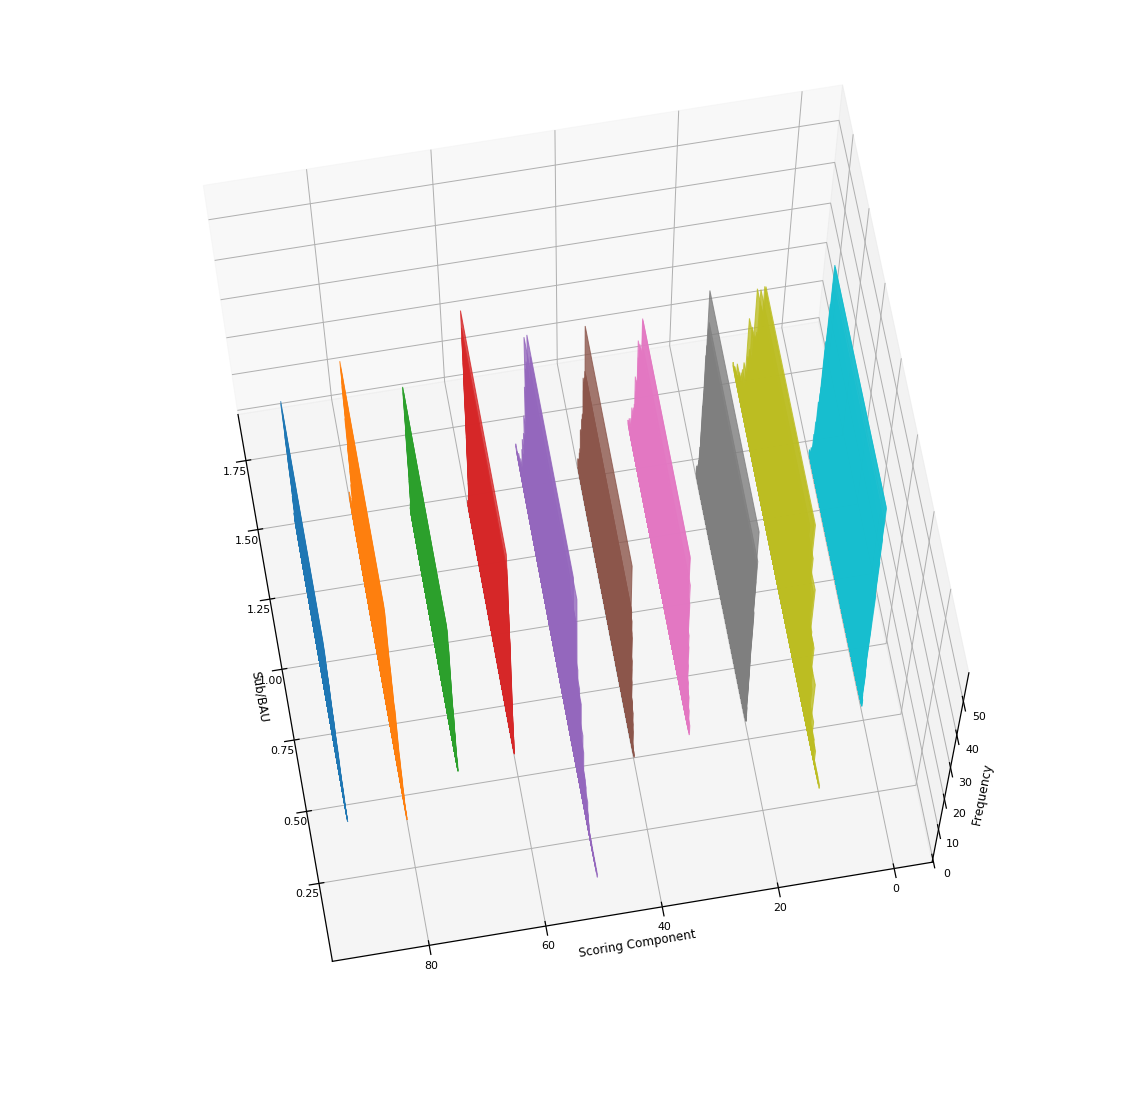

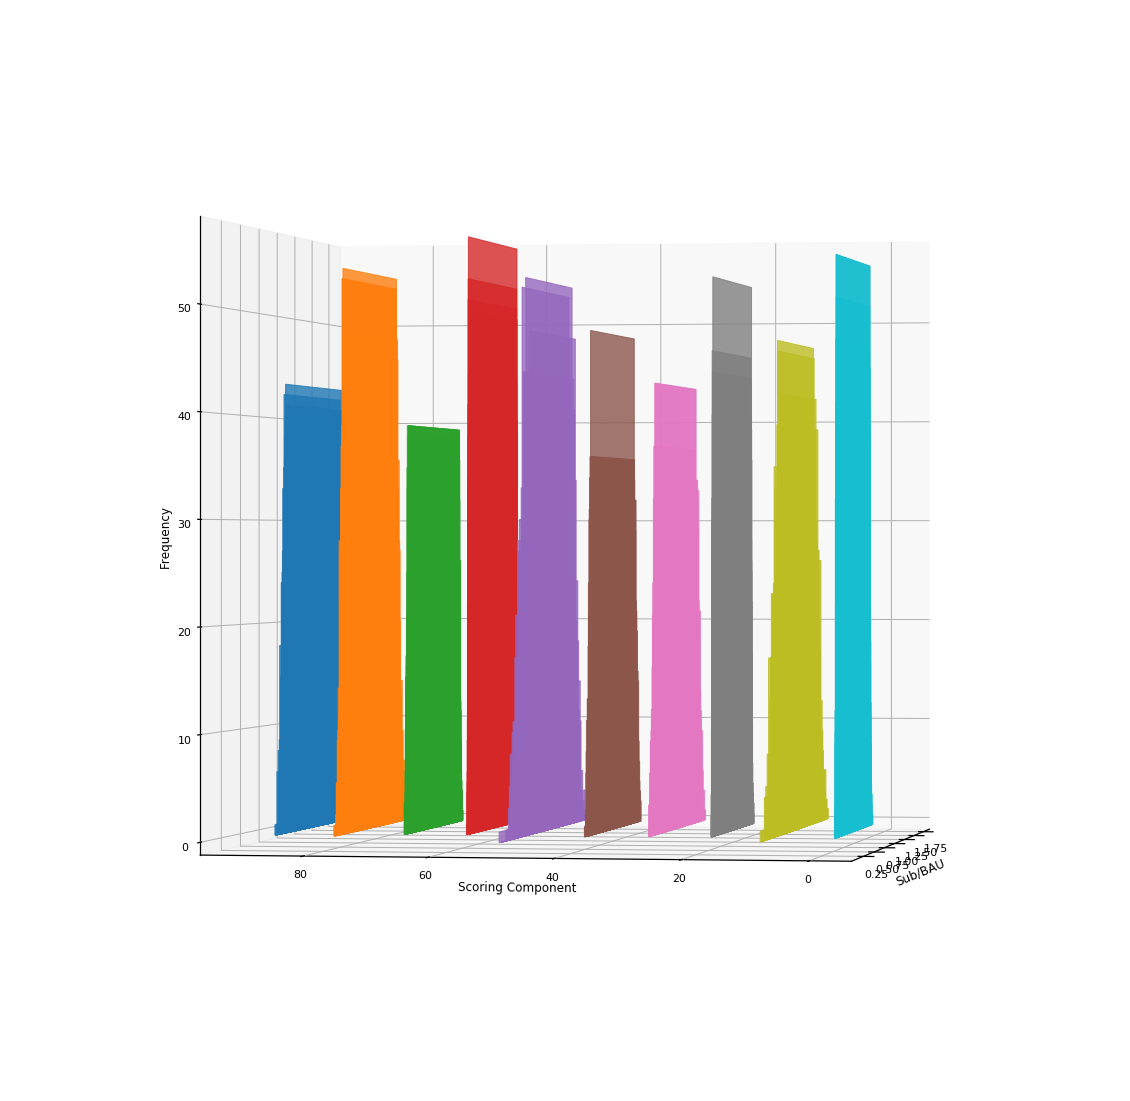

In [27]:
colors = sns.color_palette("tab10",10)



views = [(70,170),(0,190)]

for m,n in enumerate(views):
    fig = plt.figure(num=m,figsize=(20,20))
    ax = fig.add_subplot(1,1,1, projection='3d')
    nbins = 50
    for i,z in enumerate([90,80,70,60,50,40,30, 20, 10, 0]):
        ys = wide_scores.T.iloc[i]

        hist, bins = np.histogram(ys, bins=nbins)
        xs = (bins[:-1] + bins[1:])/2

        ax.bar(xs, hist, zs=z, zdir='y', color=colors[i], ec=colors[i], alpha=0.8)

    ax.set_xlabel('Sub/BAU')
    ax.set_ylabel('Scoring Component')
    ax.set_zlabel('Frequency')

# ax.set_yticklabels(['A','B','C','D','E','F','G','H','I','J'])

    ax.view_init(n[0], n[1])
    plt.show()



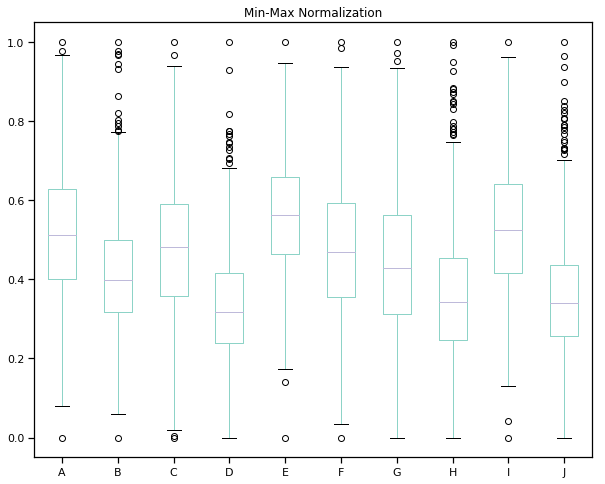

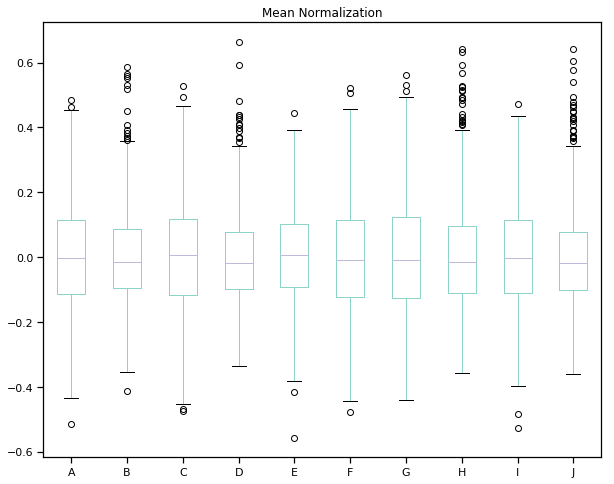

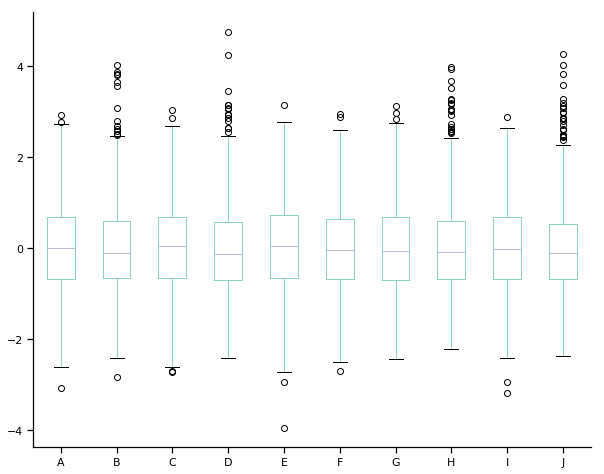

In [32]:
columns = ['A','B','C','D','E','F','G','H','I','J']
mins = np.nanmin(wide_scores.values.astype(float),axis=0)
maxs = np.nanmax(wide_scores.values.astype(float),axis=0)
denom = maxs-mins
means = np.nanmean(wide_scores.values,axis=0)
variances = wide_scores.values.var(axis=0)
stds = wide_scores.values.std(axis=0)

# min-max normalization
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set_palette('Set3')
pd.DataFrame((wide_scores.values-mins)/denom,columns=columns).plot(kind='box',title='Min-Max Normalization',ax=ax)
plt.savefig('img/min_max_norm.png',format='png',dpi=150)
plt.show()

# mean normalization
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set_palette('Set3')
pd.DataFrame((wide_scores.values-means)/denom,columns=columns).plot(kind='box',title='Mean Normalization',ax=ax)
plt.savefig('img/mean_norm.png',format='png',dpi=150)
plt.show()

# standardization
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set_palette('Set3')
pd.DataFrame(((wide_scores.values-means)/stds),columns=columns).plot(kind='box',ax=ax)
sns.despine()
plt.savefig('img/standardization.png',format='png',dpi=150)
plt.show()

In [35]:

dict(zip(columns,wide_scores.columns.values))

{'A': 'Accessibility: Number of secondary locations accessible within 15 minutes',
 'B': 'Accessibility: Number of work locations accessible within 15 minutes',
 'C': 'Congestion: average vehicle delay per passenger trip',
 'D': 'Congestion: total vehicle miles traveled',
 'E': 'Level of service: average bus crowding experienced',
 'F': 'Level of service: average on-demand ride wait times',
 'G': 'Level of service: average trip expenditure - secondary',
 'H': 'Level of service: average trip expenditure - work',
 'I': 'Mass transit level of service intervention: costs and benefits',
 'J': 'Sustainability: Total PM 2.5 Emissions'}

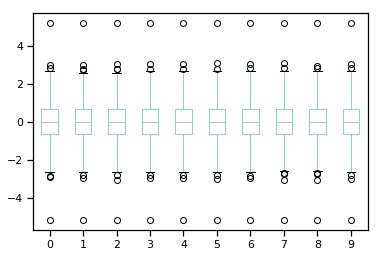

In [36]:
from sklearn.preprocessing import *
transformer = QuantileTransformer(output_distribution='normal')
fitted = transformer.fit(wide_scores.values)
pd.DataFrame(fitted.transform(wide_scores.values)).plot(kind='box')



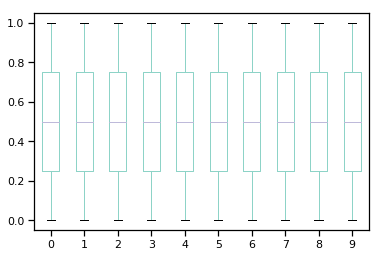

In [37]:
transformer = QuantileTransformer(output_distribution='uniform')
fitted = transformer.fit(wide_scores.values)
pd.DataFrame(fitted.transform(wide_scores.values)).plot(kind='box')

ValueError: cannot reshape array of size 806 into shape (401,)

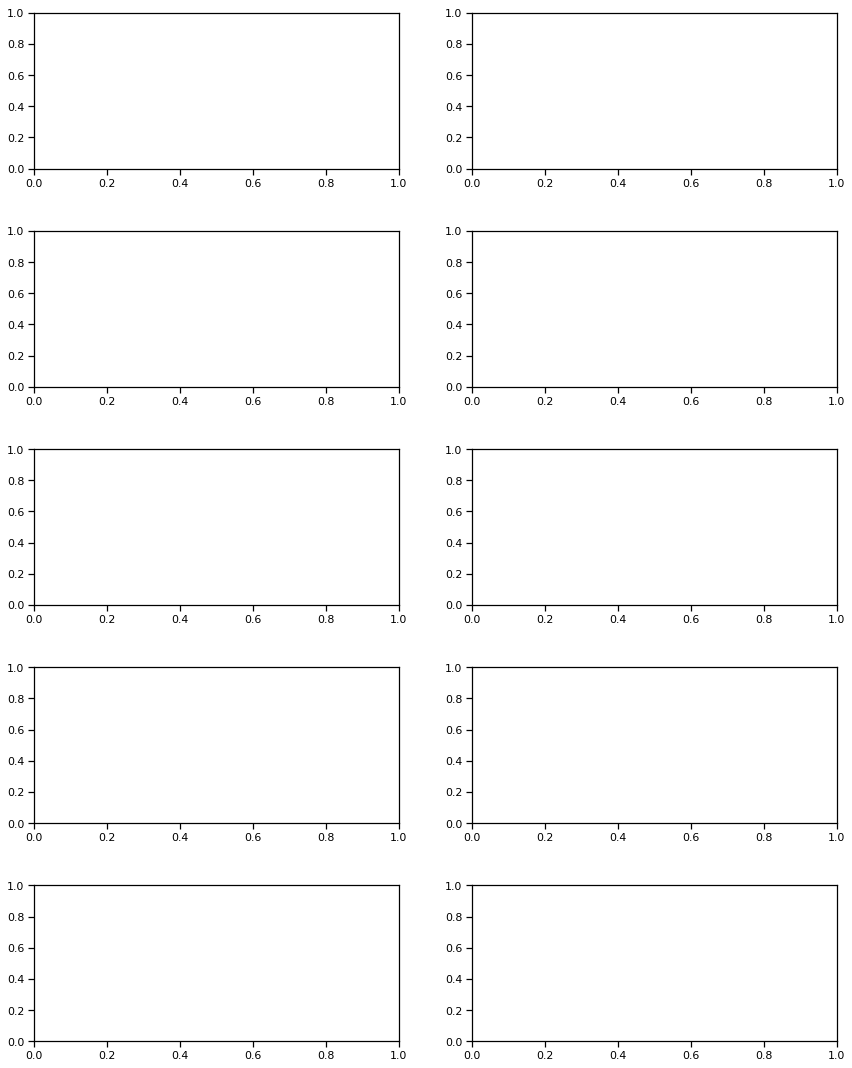

In [38]:
import scipy.stats as ss
fig,axes=plt.subplots(5,2,figsize=(12,15))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4)

i = 0
for m in range(5):
    for n in range(2):
        ax = axes[m][n]
        x = wide_scores.T.iloc[i].values
        xt, maxlog, interval=ss.boxcox(x,alpha=0.05)

        x1=x.reshape(401)
        x1=(x1 - x1.mean()) / (x1.max() - x1.min())

        xt1=xt.reshape(401)
        xt1=(xt1 - xt1.mean()) / (xt1.max() - xt1.min())

        sns.kdeplot(x1, shade=True, label="Raw (normalized)" ,ax=ax);
        sns.kdeplot(xt1, shade=True, label="Transformed (normalized)" ,ax=ax);
        ax.set_frame_on(False)
        ax.set_title(columns[i])
        ax.set_ylim(0.0,2.75)
        ax.annotate('Raw:\n mean: 0.0\n std: {:.3}'.format(x1.std()),(-0.6,1.55))
        ax.annotate('Transformed:\n mean: 0.0\n std: {:.3}'.format(xt1.std()),(0.3,1.55))
        if i!=0:
            ax.get_legend().remove()
        else:
            ax.legend(loc='lower left')
        i+=1
#             plt.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


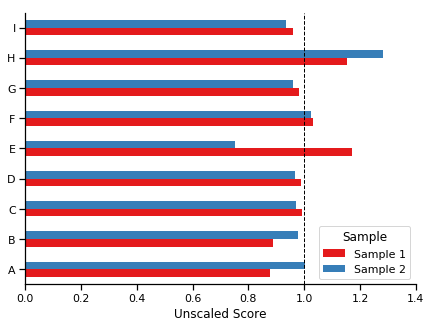

In [339]:
sns.set_context('notebook')
sns.set_palette('Set1')
fig, ax = plt.subplots()
fig.set_size_inches(7,5)



sample1 = pd.Series(dict(zip(wide_scores.columns.tolist(),np.squeeze(wide_scores.loc["C9_RS10-kby8fqop"].values.reshape(1, -1)).tolist())))
sample2 = pd.Series(dict(zip(wide_scores.columns.tolist(),np.squeeze(wide_scores.loc["C9_RS26-9519154u"].values.reshape(1, -1)).tolist())))


std_raw_scores = pd.DataFrame({"Sample 1":sample1,"Sample 2":sample2})
# sns.barplot(data=std_raw_scores)
std_raw_scores.index.name="Score Component"
std_raw_scores.columns.name='Sample'
std_raw_scores.drop('Level of service: average on-demand ride wait times',inplace=True)
std_raw_scores.index=['A','B','C','D','E','F','G','H','I']
std_raw_scores.plot(kind='barh',ax=ax)
plt.axvline(x=1.0,linewidth=1, color='k', ls='dashed', label = "baseline")
plt.xlabel("Unscaled Score")
plt.xlim(xmax = 1.4)
sns.despine()
plt.savefig('img/unscaled_sample_scores.png',format='png',dpi=150,bbox_inches="tight")

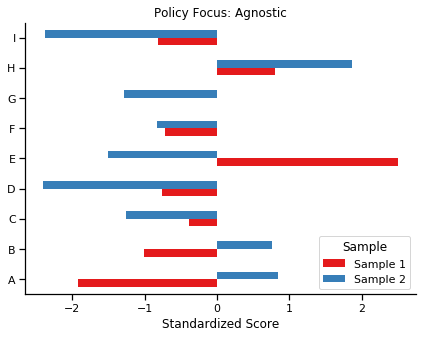

In [526]:
sns.set_context('notebook')
sns.set_palette('Set1')
fig, ax = plt.subplots()
fig.set_size_inches(7,5)


sc_fit = StandardScaler().fit(wide_scores.values)
sample1 = pd.Series(dict(zip(wide_scores.columns.tolist(),np.squeeze(sc_fit.transform(wide_scores.loc["C9_RS10-kby8fqop"].values.reshape(1, -1))).tolist())))
sample2 = pd.Series(dict(zip(wide_scores.columns.tolist(),np.squeeze(sc_fit.transform(wide_scores.loc["C9_RS26-9519154u"].values.reshape(1, -1))).tolist())))

# flip accessibility:
# sample1.iloc[0:2]=np.reciprocal(sample1.iloc[0:2])

std_raw_scores = pd.DataFrame({"Sample 1":sample1,"Sample 2":sample2})
# sns.barplot(data=std_raw_scores)
std_raw_scores.index.name="Score Component"
std_raw_scores.columns.name='Sample'
std_raw_scores.drop('Level of service: average on-demand ride wait times',inplace=True)
std_raw_scores.index=['A','B','C','D','E','F','G','H','I']
std_raw_scores.plot(kind='barh',ax=ax)
# plt.axvline(x=1.0,linewidth=1, color='k', ls='dashed', label = "baseline")
plt.xlabel("Standardized Score")
ax.set_title('Policy Focus: Agnostic')
# plt.xlim(right = 0.7,left=-0.7)

sns.despine()
plt.savefig('img/Policy Agnostic_standardized_scores.png',format='png',dpi=150,bbox_inches="tight")
# plt.xlim(xmax = 1.4)

In [382]:
wt_df = pd.read_clipboard()
wt_df.columns = sample1.index
wt_df.index = ["System efficiency",
"Sustainability",
"Personal Mobility",
"Transit Operations"]
wt_df.index.name = "Policy Focus"
wt_df.drop('Level of service: average on-demand ride wait times',inplace=True,axis=1)

In [525]:
pa_wts = pd.Series(dict(list(zip(wt_df.columns.values,np.ones(wt_df.shape[1])))),name='Policy Agnostic')
wt_df=wt_df.append(pa_wts)

In [383]:
wt_df.to_csv("policy_weights.csv")

In [527]:
sample1.drop('Level of service: average on-demand ride wait times',inplace=True)
sample2.drop('Level of service: average on-demand ride wait times',inplace=True)

In [528]:
wt_denom=wt_df.values.sum(axis=1)
wt_norm = (wt_df.T/wt_denom).T
sample1_wt = wt_norm*sample1
sample2_wt = wt_norm*sample2

In [549]:
np.expand_dims(sample1.values,1)*(wt_df.T/wt_denom)

Policy Focus,System efficiency,Sustainability,Personal Mobility,Transit Operations,Policy Agnostic
Score Component,,,,,
Accessibility: Number of secondary locations accessible within 15 minutes,-0.120608,-0.160811,-0.304694,-0.148441,-0.214414
Accessibility: Number of work locations accessible within 15 minutes,-0.063242,-0.084322,-0.159769,-0.077836,-0.112430
Congestion: average vehicle delay per passenger trip,-0.071806,-0.031914,-0.020156,-0.029459,-0.042552
Congestion: total vehicle miles traveled,-0.141808,-0.126052,-0.039806,-0.058178,-0.084034
Level of service: average bus crowding experienced,0.313199,0.208799,0.395619,0.578213,0.278399
Level of service: average trip expenditure - secondary,-0.044539,-0.059385,-0.112519,-0.054817,-0.079180
Level of service: average trip expenditure - work,-0.000276,-0.000368,-0.000698,-0.000340,-0.000491
Mass transit level of service intervention: costs and benefits,0.149785,0.066571,0.042045,0.184351,0.088761
Sustainability: Total PM 2.5 Emissions,-0.051143,-0.204571,-0.043068,-0.062945,-0.090921


In [284]:
std_wt_scores = pd.DataFrame({"Sample 1":sample1_wt.loc[policy].T,"Sample 2":sample2_wt.loc[policy].T})
std_wt_scores.drop('Level of service: average on-demand ride wait times',inplace=True)
for k,v in dict(list(zip(['A','B','C','D','E','F','G','H','I'],std_wt_scores.index.values))).items():
    print("{}: {}".format(k,v))

A: Accessibility: Number of secondary locations accessible within 15 minutes
B: Accessibility: Number of work locations accessible within 15 minutes
C: Congestion: average vehicle delay per passenger trip
D: Congestion: total vehicle miles traveled
E: Level of service: average bus crowding experienced
F: Level of service: average trip expenditure - secondary
G: Level of service: average trip expenditure - work
H: Mass transit level of service intervention: costs and benefits
I: Sustainability: Total PM 2.5 Emissions


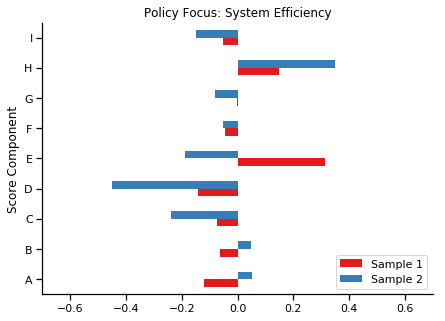

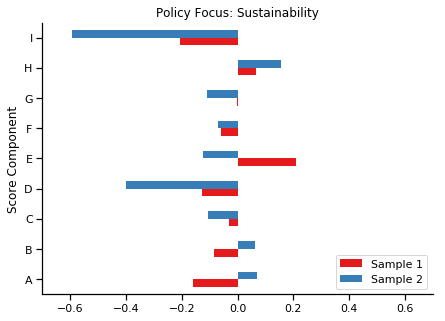

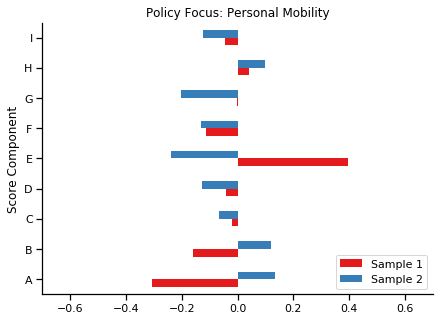

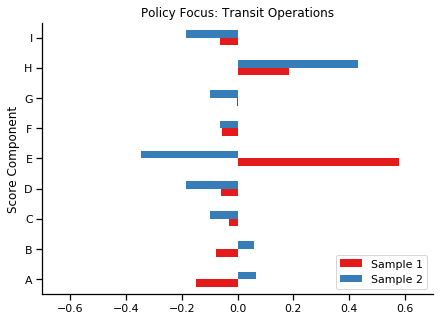

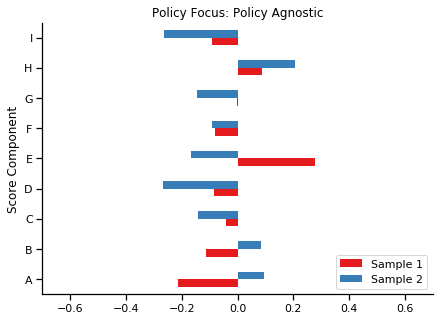

In [529]:
dfs = []

for policy in sample1_wt.index.values:
    sns.set_context('notebook')
    sns.set_palette('Set1')
    fig, ax = plt.subplots()
    fig.set_size_inches(7,5)
    std_wt_scores = pd.DataFrame({"Sample 1":sample1_wt.loc[policy].T,"Sample 2":sample2_wt.loc[policy].T})

    std_wt_scores.index=['A','B','C','D','E','F','G','H','I']
    std_wt_scores.index.name="Score Component"
    std_wt_scores.columns.name='Sample'
    dfs.append(std_wt_scores)
    std_wt_scores.plot(kind='barh',ax=ax)
    ax.set_title('Policy Focus: {}'.format(policy.title()))
    plt.xlim(right = 0.7,left=-0.7)
    sns.despine()
    plt.legend(loc='lower right')
    plt.savefig('img/{}_standardized_sample_scores.png'.format(policy),format='png',dpi=150,bbox_inches="tight")

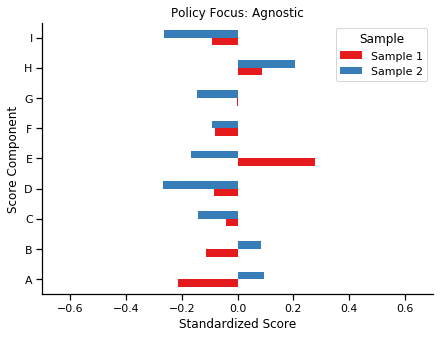

In [500]:
sns.set_context('notebook')
sns.set_palette('Set1')
fig, ax = plt.subplots()
fig.set_size_inches(7,5)


sc_fit = StandardScaler().fit(wide_scores.values)
sample1 = pd.Series(dict(zip(wide_scores.columns.tolist(),np.squeeze(sc_fit.transform(wide_scores.loc["C9_RS10-kby8fqop"].values.reshape(1, -1))).tolist())))/9
sample2 = pd.Series(dict(zip(wide_scores.columns.tolist(),np.squeeze(sc_fit.transform(wide_scores.loc["C9_RS26-9519154u"].values.reshape(1, -1))).tolist())))/9

# flip accessibility:
# sample1.iloc[0:2]=np.reciprocal(sample1.iloc[0:2])

std_raw_scores = pd.DataFrame({"Sample 1":sample1,"Sample 2":sample2})
std_raw_scores.drop('Level of service: average on-demand ride wait times',inplace=True)
std_raw_scores.index=['A','B','C','D','E','F','G','H','I']
std_raw_scores.index.name="Score Component"
std_raw_scores.columns.name='Sample'

dfs.append(std_raw_scores)
# sns.barplot(data=std_raw_scores)


std_raw_scores.plot(kind='barh',ax=ax)
# plt.axvline(x=1.0,linewidth=1, color='k', ls='dashed', label = "baseline")
plt.xlabel("Standardized Score")
ax.set_title('Policy Focus: Agnostic')
plt.xlim(right = 0.7,left=-0.7)

sns.despine()
plt.savefig('img/Policy Agnostic_standardized_scores.png',format='png',dpi=150,bbox_inches="tight")
# plt.xlim(xmax = 1.4)

In [535]:
full_df['Sustainability'].sum()

Sample
Sample 1   -0.392053
Sample 2   -1.113959
dtype: float64

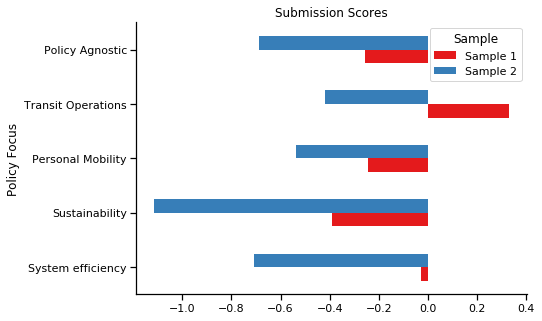

In [503]:
sns.set_context('notebook')
sns.set_palette('Set1')
fig, ax = plt.subplots()
fig.set_size_inches(7,5)
sns.despine()
final_scores = full_df.sum(axis=0).unstack().plot(kind='barh',ax=ax)
ax.set_title('Submission Scores')
plt.savefig('img/final_scores.png',format='png',dpi=150,bbox_inches="tight")

In [ ]:

fig, ax = plt.subplots()
fig.set_size_inches(7,5)
sns.barplot(data = raw_scores_random, x= "Raw Score", y = "Subscores", hue = "sample")
plt.axvline(x=1.0,linewidth=1, color='k', ls='dashed', label = "baseline")
plt.legend(bbox_to_anchor=(1.01,1), loc = "upper left")
plt.yticks(fontsize = 11)
plt.xlabel("Raw Score")
plt.ylabel("Score component")
plt.xlim(xmax = 1.4)
plt.title("Raw Subscores", fontweight = "bold", pad=12, fontsize = 15)
plt.savefig("Raw_Subscores-Good_vs_Bad_sample", bbox_inches="tight")
plt.show()

In [552]:
freq_df=pd.read_csv("/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/r5/sf_freq_summary.csv")

In [553]:
freq_df

,Route,AM Peak Frequency,Midday Frequency,PM Peak Frequency,Evening Frequency,AM Peak Speed,Midday Speed,PM Peak Speed,Evening Speed,Trips/Day,First trip,Last trip
0,1 South Kiwanis Avenue/VA Medical Center towar...,-,-,-,-,10,11,10,11,20,5:45 AM,6:45 PM
1,2 S. Western/Sanford towards The Bus Stop (TBS...,-,-,-,-,11,11,11,11,19,5:45 AM,6:45 PM
2,3 Downtown/Southwest Connector towards The Bus...,-,-,-,-,11,11,11,11,28,5:15 AM,8:45 PM
3,4 East 10th Street/East 12th Street towards Th...,-,-,-,-,14,14,14,14,20,5:45 AM,6:45 PM
4,5 South Phillips Avenue/Avera McKennan Hospita...,-,-,-,-,16,15,15,15,20,5:45 AM,6:45 PM
5,6 North Prairie Avenue towards The Bus Stop (T...,-,-,-,-,12,12,12,12,23,5:45 AM,9:15 PM
6,7 North Cleveland/East 6th Street/Arrowhead Pa...,-,-,-,-,13,13,13,13,27,5:45 AM,8:45 PM
7,8 North Industrial towards The Bus Stop (TBS) ...,-,-,-,-,18,18,18,18,18,5:35 AM,6:45 PM
8,9 South Sycamore/East 26th Street towards The ...,-,-,-,-,14,15,15,16,21,5:45 AM,8:45 PM
9,10 Hayward/West Side towards The Bus Stop (TBS...,-,-,-,-,16,16,16,16,21,5:45 AM,8:45 PM


In [6]:
import sys
from pathlib import Path
import json

import pandas as pd
import numpy as np
import shapely.geometry as sg
import matplotlib

DIR = Path('..')
sys.path.append(str(DIR))

import gtfstk as gt

DATA_DIR = DIR/'prize_starter_kit/reference-data/sioux_faux/sioux_faux_bus_lines/gtfs_data/'

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
path = "/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/r5/sf_gtfs.zip"
gtfs=gt.list_gtfs(path)

In [9]:
feed = gt.read_gtfs(path, dist_units='km')
print(feed)

* agency --------------------
	  agency_id                      agency_url agency_lang       agency_name  \
0       217  http://www.siouxfalls.org/sam/          en  Sioux Area Metro   

   agency_phone agency_timezone agency_fare_url  
0  605-367-7151      US/Central             NaN  
* calendar --------------------
	         service_id                        service_name  monday  tuesday  \
0  c_676_b_219_d_31  Year Round Service (Monday-Friday)       1        1   
1  c_676_b_219_d_32  Year Round Service (Saturday only)       0        0   

   wednesday  thursday  friday  saturday  sunday start_date  end_date  
0          1         1       1         0       0   20140618  20200101  
1          0         0       0         1       0   20140618  20200101  
* calendar_dates --------------------
	         service_id      date      holiday_name  exception_type
0  c_676_b_219_d_31  20200101     New Years Day               2
1  c_676_b_219_d_31  20191225     Christmas Day               2
2  c_

In [12]:
feed.validate()


/anaconda3/lib/python3.7/site-packages/gtfstk/validators.py:1377: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  g = pd.concat([g, feed.calendar_dates])


,type,message,table,rows
0,warning,Unrecognized column service_name,calendar,[]
1,warning,Unrecognized column holiday_name,calendar_dates,[]
2,warning,Unrecognized column agency_id,fare_attributes,[]
3,warning,Unrecognized column feed_license,feed_info,[]
4,warning,Unrecognized column feed_contact_email,feed_info,[]
5,warning,Unrecognized column feed_contact_url,feed_info,[]
6,warning,Unrecognized column feed_id,feed_info,[]
7,warning,Unrecognized column route_sort_order,routes,[]
8,warning,Unrecognized column min_headway_minutes,routes,[]
9,warning,Unrecognized column eligibility_restricted,routes,[]


In [13]:
trip_stats = feed.compute_trip_stats()
trip_stats.head().T

,235,236,237,238,106
trip_id,t_75335_b_219_tn_1,t_75335_b_219_tn_2,t_75335_b_219_tn_3,t_75336_b_219_tn_1,t_73194_b_219_tn_1
route_id,1340,1340,1340,1340,1340
route_short_name,1,1,1,1,1
route_type,3,3,3,3,3
direction_id,NaN,NaN,NaN,NaN,NaN
shape_id,p_3333,p_3333,p_3333,p_3333,p_3333
num_stops,41,41,41,41,41
start_time,05:45:00,06:15:00,06:45:00,07:20:00,07:45:00
end_time,06:39:00,07:09:00,07:39:00,08:19:00,08:39:00
start_stop_id,767253,767253,767253,767253,767253


In [14]:
feed = feed.append_dist_to_stop_times(trip_stats)
feed.stop_times.head().T

,0,1,2,3,4
trip_id,t_13118_b_219_tn_0,t_13118_b_219_tn_0,t_13118_b_219_tn_0,t_13118_b_219_tn_0,t_13118_b_219_tn_0
arrival_time,07:20:00,NaN,NaN,NaN,NaN
departure_time,07:20:00,NaN,NaN,NaN,NaN
stop_id,767253,767291,767292,767293,767294
stop_sequence,1,2,3,4,5
stop_headsign,NaN,NaN,NaN,NaN,NaN
pickup_type,0,0,0,0,0
drop_off_type,0,0,0,0,0
shape_dist_traveled,0,NaN,NaN,NaN,NaN
timepoint,0,0,0,0,0


In [38]:
arrivals = pd.to_timedelta(feed.stop_times.arrival_time)
arrivals

0       07:20:00
1            NaT
2            NaT
3            NaT
4            NaT
5            NaT
6            NaT
7       07:28:00
8            NaT
9            NaT
10           NaT
11           NaT
12           NaT
13           NaT
14           NaT
15      07:35:00
16           NaT
17           NaT
18           NaT
19           NaT
20      07:47:00
21           NaT
22           NaT
23           NaT
24           NaT
25           NaT
26           NaT
27      08:04:00
28           NaT
29           NaT
          ...   
13995        NaT
13996   19:00:00
13997        NaT
13998        NaT
13999        NaT
14000        NaT
14001   19:07:00
14002        NaT
14003        NaT
14004        NaT
14005        NaT
14006        NaT
14007        NaT
14008   19:24:00
14009        NaT
14010        NaT
14011        NaT
14012        NaT
14013        NaT
14014        NaT
14015        NaT
14016   19:30:00
14017        NaT
14018        NaT
14019        NaT
14020        NaT
14021        NaT
14022        N

In [44]:
index = pd.Index(arrivals.values)

In [47]:
arrivals.index = index

In [50]:
import scipy.interpolate as si

In [55]:
start = None
end = None
for time in feed.stop_times.arrival_time:
    if not np.isnan(time) and (start is None and end is None):
        start = pd.to_timedelta(time)
    if not np.isnan(time) and (start is not None and end is None):
        end = pd.to_timedelta(time)
    if start is not None and end is not None:
        time_range = pd.time_range(start,end)
        print(time_range)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [58]:
feed.routes.route_id

0     1340
1     1341
2     1350
3     1351
4     1342
5     1343
6     1344
7     1345
8     1346
9     1347
10    1348
11    1349
Name: route_id, dtype: object